In [1]:
import numpy as np

from jax import numpy as jp

from jax import jit,grad
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import cvxpy as cp

from RKHS import Gram

In [2]:
def h(r,c,l):
    return c * jp.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(jp.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

In [3]:
def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,jp.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*jp.log(jp.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*jp.log(jp.linalg.det(KA))

In [4]:
def rand_search(x0,R,objective,T,step_size):
    xss = []
    vals = []
    for _ in range(50000):
        
        xs = [x0]
        for i in range(T-1):
            
            cand_x = 0
            while True:
                r = step_size

                theta = np.random.rand()*2*np.pi

                cand_x = xs[-1]+r*np.array([np.cos(theta),np.sin(theta)])

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)

        xs = np.array(xs)
        val = objective(xs)
        
        xss.append(xs)
        vals.append(val)
            
    return xss[np.argmax(vals)],np.max(vals),xss,vals

In [5]:
def projected_x_gradient(objective,initial_states,ref,R,T,step_size):
    n_iter = 100
    delta_tolerance = 1e-7 # If ||z_{t+1}-z_t||<delta_tolerance, terminate the algorithm.
    eta = 0.01 # The learning rate for gradient update

    pg_zs = []
    
    def project(z,ref,R,step_size):
        T = len(z)
        N = len(ref)
        # Setup the projection optimization problem

        z_proj = cp.Variable(z.shape)

        # Step size constraints
        constraints = [cp.norm(z_proj[i+1]-z_proj[i])<=step_size for i in range(T-1)] 

        # # Bounded search region constraints
        constraints += [cp.norm(z_proj[i]-ref[j])<=R[i,j] for i in range(T) for j in range(N)]

        prob = cp.Problem(cp.Minimize(cp.norm(z_proj-z)),constraints)

        prob.solve()

        return z_proj.value

    for k,z_0 in enumerate(initial_states):

        print('{}th start outof {}.'.format(k,len(initial_states)))

        # z_0 = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size # set z_0 to be the straight line

        z = np.array(z_0)

        g = jit(grad(objective))
        
        best_z = z_0
        best_val = objective(z_0)

        for _ in range(n_iter):
            z += eta * g(z) # Gradient step
            z = project(z,ref,R,step_size) # Projection
            if objective(z)> best_val:
                best_z = z

        pg_zs.append(best_z)
    

        ob = [objective(z) for z in pg_zs]

        return pg_zs[np.argmax(ob)]

In [6]:

T = 7

c = 1
l = 1
var_0 = 0.01
objective = jit(lambda z: GPMI(z,c=c,l=l,var_0=var_0))


search_region_center = np.array([0,0])
search_region_radius = 1
step_size = 1

In [7]:
kernel = partial(k,c=c,l=l)

In [8]:
objective(np.random.rand(T,2))

DeviceArray(8.985386, dtype=float32)

# Random search I

**No** bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    x_t\gets x_{t-1} + D * \text{ random unit vector}
$$


In [9]:
_,_,xss,vals = rand_search(search_region_center,\
                         np.inf,objective,T,step_size)

In [10]:
top_n = 5

top_xs = np.array(xss)[np.argsort(vals)[-top_n:]]

# Solve for the upper bound


$$
    \max_S \log(\det(I+\sigma^{-2}S))\\
    S_{ii}=c\\
    S_{i,i+1}=S_{i+1,i}\geq d\\
    S\succeq 0\\
    (\text{Without admissibility constraints})
$$

In [11]:
n = T
var = var_0


d = h(step_size,c=c,l=l)

I = np.eye(n)

S = cp.Variable((n,n),symmetric=True)

constraints = [cp.diag(S)==c]

constraints+=[S[i,i+1]>=d for i in range(0,n-1)]

constraints+=[S>>0]

prob = cp.Problem(cp.Maximize(1/2*cp.log_det(I+ S/var)),constraints)

upper_bound = prob.solve()

# Projected Gradient in $z=x_{1:T}$

In [12]:

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([1e2*np.ones(T)]).T
R[0,0] = 0

projected_x_gradient(objective,top_xs,ref,R,T,step_size)

0th start outof 5.


array([[-2.60233875e-03,  1.03017638e-03],
       [ 9.73127324e-01, -2.33939805e-01],
       [ 1.57539048e+00, -1.03853007e+00],
       [ 6.91621251e-01, -1.52193179e+00],
       [ 1.14633373e+00, -2.41946525e+00],
       [ 2.72618053e-01, -2.92007512e+00],
       [ 9.37628614e-01, -3.67558938e+00]])

# Compare the solutions and the upper bound

In [42]:
sols = {'Random Search': top_xs[-1],
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size,
        'PG': best_z
       }


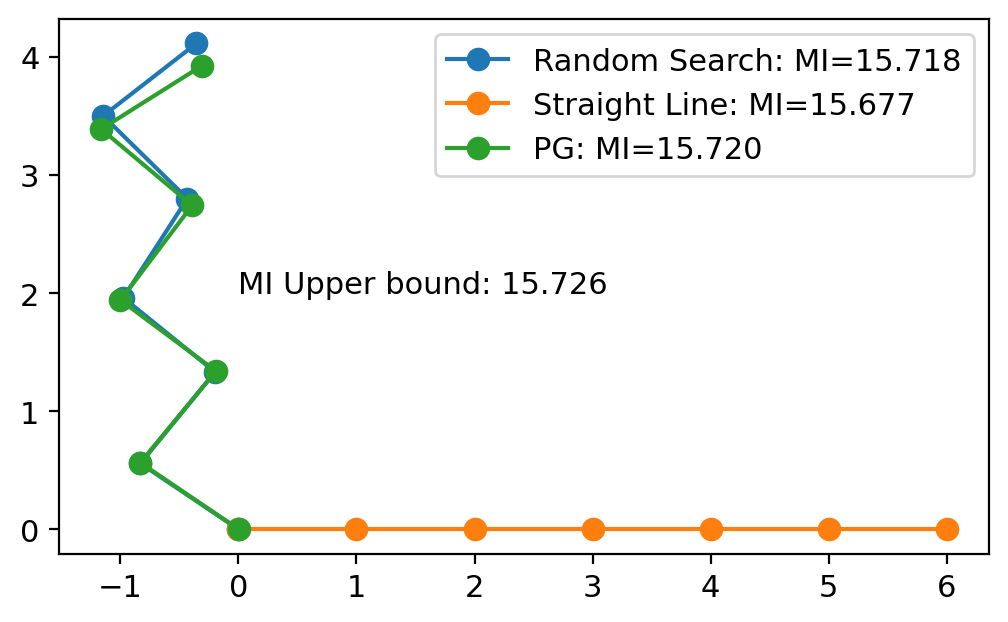

In [43]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.3f}".format(key,objective(val)))
    
    plt.gca().set_aspect('equal')

plt.text(0.,2.,'MI Upper bound: {:.3f}'.format(upper_bound))
# circ = plt.Circle(search_region_center,search_region_radius,label='Search Region Boundary',fill=False)
# plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()